In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import os

tf.random.set_seed(42) # for reproducibility

/home/chananchidas/miniconda3/envs/BigDataScience/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-04 13:17:07.638145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 13:17:07.680443: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



# Practical session 10: Deep Learning

<div class="alert alert-block alert-info">
    <h2>Table of Contents </h2><a class="anchor" id="top"></a>
    <br><a href="#section_1">1. Data loading</a>
    <br><a href="#section_2">2. Preprocessing the dataset</a>
    <br><a href="#section_3">3. Implementing a neural network</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_3_1">3.1 Define the architecture</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_3_2">3.2 Define the loss function, optimizer, and metrics</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_3_3">3.3 Run the learning procedure to train the network</a>
    <br>&nbsp;&nbsp;&nbsp;&nbsp;<a href="#section_3_4">3.4 Inspect classifier performance</a>
    <br><a href="#section_4">Extra: A look at intermediate representations of the network</a>
</div>


## Malaria cell classification

Malaria is a blood disease caused by the *Plasmodium* parasite, and is transmitted through the bite of the female *Anopheles* mosquito. The disease is mostly diagnosed by counting parasitized blood cells in a blood smear under a microscope. However, manual cell counting is an exhausting, error-prone procedure. This can negatively affect the quality of the diagnosis [[1]](https://peerj.com/articles/4568/). Especially in *resource-constrained* regions of the world, difficult working conditions lead to poor diagnosis quality [[2]](https://lhncbc.nlm.nih.gov/publication/pub9932) .

In this practical session we will develop a deep learning pipeline that will aid in improving malaria diagnosis by automating infected cell counting. To this end we will use the Malaria cell dataset [[2]](https://lhncbc.nlm.nih.gov/publication/pub9932) to train a neural network that predicts a cell's infection state based on a microscopy image of it. The microscopy images were acquired using a smartphone attached to a small portable microscope.

To set up the deep learning pipeline we will go through these steps:
- Load the dataset
-  Preprocess the dataset
-  Define a neural network
-  Define the learning procedure
-  Train the neural network
- Inspect the network's performance

We will use the [TensorFlow machine learning framework](http://tensorflow.org) to implement these steps.

<h2 style="display: inline">1. Data loading</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_1"></a> 

### Device setup

In [2]:
from tensorflow.python.client import device_lib

def select_device(prefer_gpu=True):
    local_device_protos = device_lib.list_local_devices()
    gpus = [x.name for x in local_device_protos if x.device_type == 'GPU']
    if (len(gpus) > 0) and prefer_gpu:
        return gpus[0]
    else:
        return [x.name for x in local_device_protos if x.device_type == 'CPU'][0]

In [3]:
# This code sets the device to use to GPU if you have one available
device = select_device(prefer_gpu=True)
device

2023-05-04 13:17:08.541890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/device:GPU:0'

2023-05-04 13:17:08.571668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 13:17:08.583657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 13:17:08.583781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 13:17:08.891045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 13:17:08.891161: I tensorflow/compiler/xla/stream_executo

The above `device` is used in the notebook to select where code is executed. This is done with a `with` statement:

```
with tf.device(device):
    # code
```

### Load the Malaria dataset

We use the `tensorflow-datasets` package to load the malaria dataset.

In [4]:
builder = tfds.builder('malaria')

In [5]:
# This takes around 1.5 minutes
builder.download_and_prepare()

Look at some info about the dataset.

In [6]:
builder.info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/home/chananchidas/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin 

Use the builder to extract a TensorFlow Dataset for efficient access to the images.
We also split the dataset into training data for training the neural network parameters, and testing data for evaluating the network's performance on unseen data.

In [7]:
with tf.device(device):
    train_ds, test_ds = (
        builder.as_dataset(as_supervised=True, split="train[:80%]"),
        builder.as_dataset(as_supervised=True, split="train[-20%:]")
    )

2023-05-04 13:17:08.911341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 13:17:08.911509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 13:17:08.911585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 13:17:08.911807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 13:17:08.911896: I tensorflow/compiler/xla/stream_executo

<div class="alert alert-success">
<h3> Exercise</h3>
    
Plot some images from `train_ds` to get an idea of what the data looks like. Have a look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to see how you can *take* a number of images from the dataset.
</div>

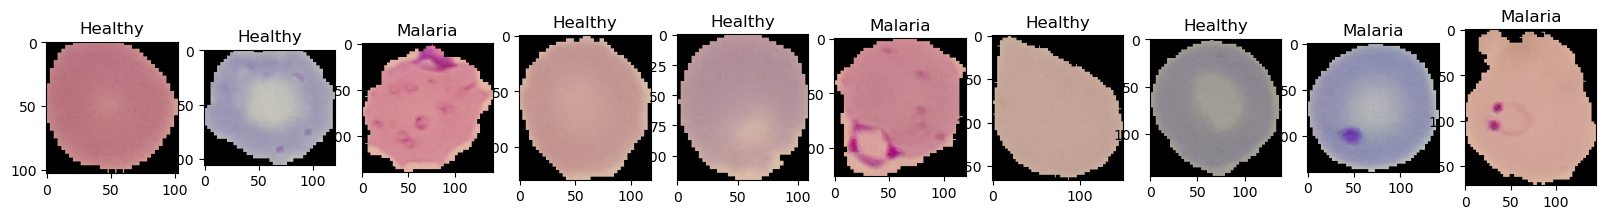

In [8]:
n_images = 10

# select some images from the dataset
images = train_ds.take(n_images)

fig, axes = plt.subplots(1, n_images, figsize=(20, 5), dpi=100)
for ax, (image, label) in zip(axes, images):
    ax.imshow(image)
    ax.set_title("Healthy" if label.numpy() == 1 else "Malaria")

<h2 style="display: inline">2. Preprocessing the dataset</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_2"></a> 

For this dataset two preprocessing operations are required:
1. Resize all images to uniform width and height, and
2. normalize the pixel value range to [0,1].

Neural networks have a fixed architecture and can therefore only take inputs of equal dimensions. This is why we have to preprocess the images to have uniform dimensions. For the Malaria dataset, we downsample the images to be 40 pixels high and 40 pixels wide. We will need the `resize_with_pad` and `resize` functions from the `tf.image` module.

Normalization of the pixel range to a [0,1] range is done to improve the stability of the weight updates. The Malaria dataset contains 8-bit RGB images, which have a maximum pixel value of 255 and a minimum of 0. If we would train the neural network using pixel values in the [0,255] range, the network's weights could grow too large causing high values during backpropagation and unstable training.

In [9]:
# Define the two preprocessing operations
def resize_images(image, label, image_width=40, image_height=40):
    """
    Resizes all images in a dataset to a uniform width and height.
    Also casts the images and labels to the float32 data type.
    """
    return (
        tf.cast(tf.image.resize_with_pad(tf.image.resize(image, (image_width, image_height)), image_width, image_height), tf.float32), 
        tf.cast(label, tf.float32)
    )

def minmax_normalization(image, label):
    """Normalizes the pixel value range of an image to [0, 1] by dividing each pixel by the maximum value in each channel."""
    return (
        image / tf.math.reduce_max(tf.reshape(image, [-1, image.shape[-1]]), axis=0), # divide each pixel in the image by the maximum value in each channel (R, G, and B)
        label
    )

<div class="alert alert-success">
<h3> Exercise</h3>
    
Apply both preprocessing functions to the train and test dataset defined earlier. Have a look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to see how you can *map* a function over the elements of a dataset.
</div>

In [10]:
# apply resize images
train_ds = train_ds.map(resize_images)
test_ds = test_ds.map(resize_images)

In [11]:
# apply minmax
train_ds = train_ds.map(minmax_normalization)
test_ds = test_ds.map(minmax_normalization)

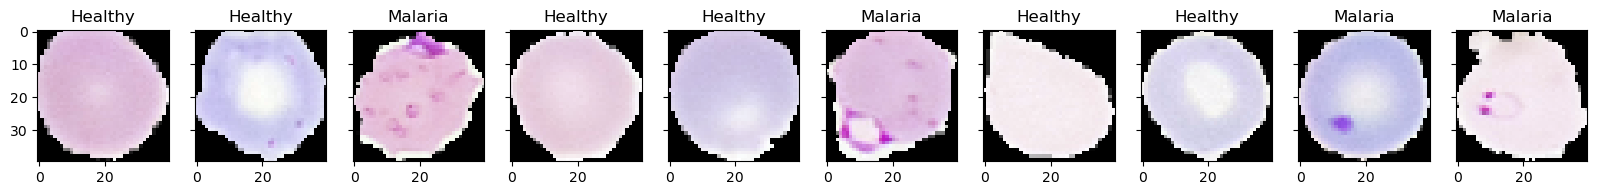

In [12]:
# have a look at the preprocessed images...

n_images = 10
fig, axes = plt.subplots(1, n_images, figsize=(20, 5), dpi=100, sharex=True, sharey=True)
for ax, (image, label) in zip(axes, train_ds.take(n_images)):
    ax.imshow(image.numpy())
    ax.set_title("Healthy" if label.numpy() == 1 else "Malaria")

The data is now preprocessed and ready to handled by the neural network that we will define in the next part.

<h2 style="display: inline">3. Implementing a neural network</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3"></a> 

We need a neural network that is capable of classifying cell images in a positive and negative class. In this case, we want it to distinguishing between a healthy and parasitized cell based on a 40x40 RGB image. For today's standards this specific problem is a fairly easy computer vision task. A simple (and efficient) _shallow_ convolutional neural network (CNN) will suffice.

<br>

<h3 style="display: inline">3.1 Define the architecture</h3> <a class="anchor" id="section_3_1"></a>

The neural network will consist out of 4 main layers: 2 feature extraction layers, and 2 classification layers.

The **feature extraction** layers are made up of [convolution](https://developers.google.com/static/machine-learning/practica/image-classification/images/convolution_overview.gif) and [max-pooling operations](https://developers.google.com/static/machine-learning/practica/image-classification/images/maxpool_animation.gif) and activation functions. They will learn to extract relevant features from the image and enable the classification layers to learn to classify cells into the healthy or parasitized category.

The extracted features get passed on to the **classification layers**, which are made up of densely connected layers, dropout connections and activation functions.

The [**activation functions**](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*XxxiA0jJvPrHEJHD4z893g.png) used in this neural network are the sigmoid, and Rectified Linear Unit (ReLU). The ReLU is used as the intermediate activation function in the feature extraction and classification layers. This function is used in many state-of-the-art image classification networks. It works well because it prevents the gradients from *vanishing* during backpropagation. The sigmoid is the activation function applied to the output of the final densely connected layer. It squeezes whatever value that comes out of the network to the 0-1 range. Ideal for binary classification!


![](https://raw.githubusercontent.com/Latheuni/BigDataCourse/main/Week10/network_diagram.jpg)

<div class="alert alert-success">
<h3> Exercise</h3>
    
Define a CNN architecture with the [TensorFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) using the above scheme as a guideline. Feel free to try out some of your own settings! The network takes RGB images as input, and has one output neuron that will produce output values between 0 (malaria) and 1 (healthy).
    
You will need the following layers:
    <ul>
    <li> `tf.keras.layers.Conv2D` (recommended to add padding)</li>
    <li> `tf.keras.layers.MaxPool2D`</li>
    <li>`tf.keras.layers.ReLU`</li>
    <li>`tf.keras.layers.Flatten`([this diagram](https://i0.wp.com/developersbreach.com/wp-content/uploads/2020/08/cnn_banner.png?fit=1200%2C564&ssl=1) may provide a hint as to where to use this layer) </li> 
    <li>`tf.keras.layers.Dense`</li>
    <li>`tf.keras.layers.Dropout`</li>
</ul>

</div>

In [13]:
with tf.device(device):
    classifier = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=(1,1), padding="same"),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=(2,2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

<h3 style="display: inline">3.2 Define the loss function, optimizer, and metrics</h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_2"></a>

To optimize the parameters of the network we need an optimization algorithm, and a loss function to minimize. In this particular case the binary cross-entropy is a good choice.

$$\textrm{BinaryCrossEntropy} = -\frac{1}{N}\sum_{i=1}^N{(y_i\cdot\log(p_i) + (1 - y_i)\cdot\log(1 - p_i))}$$

In [14]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

 As optimization algorithm we choose stochastic gradient descent (SGD). More advanced optimizers exist, but SGD is a good first choice.

In [15]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

The binary cross-entropy is a good metric for optimization, but is less interpretable. Accuracy is a more intuitive metric for assessing model performance.
$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$

In [16]:
accuracy_metric = tf.keras.metrics.BinaryAccuracy()

Finally, TensorFlow requires us to [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) all parts of the learning procedure together.

In [17]:
with tf.device(device):
    classifier.compile(optimizer=sgd_optimizer, loss=bce_loss, metrics=[accuracy_metric])

<h3 style="display: inline">3.3 Run the learning procedure to train the network</h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_3"></a>

First, we define some constants for the learning procedure.

In [18]:
epochs = 30 # How many times will the network see all training data
batch_size = 256 # How many instances will the network process in one iteration

train_len = len(list(train_ds))
test_len = len(list(test_ds))
steps_per_epoch = train_len//batch_size
test_steps = test_len//batch_size

print("Number of training objects:", train_len, "; steps:", steps_per_epoch)
print("Number of test objects:", test_len, "; steps:", test_steps)

Number of training objects: 22046 ; steps: 86
Number of test objects: 5512 ; steps: 21


Next, we iteratively update the parameters of the network using mini-batches of data (of size `batch_size`). In other words, we fit the network to the data. In pseudo-code:
```
for epoch in epochs:
    for true_labels, batch in batches:
        predictions = network(batch)
        loss = loss_function(true_labels, predictions)
        optimizer.update(network, loss)
```
The TensorFlow Keras API has several utility functions that wrap basic procedures in helper functions. One such function is `fit` ([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit)). It performs something close to the above pseudo-code on our network. All we have to do, is pass it the constants we defined above. Using helper functions is good practice as it lets us write code quicker, and it is less error-prone. However, always know what the helper functions do exactly!

Note that we save the return value of the fit function to a variable. It contains important information about the performance of our network. We will analyze this in the next part.

In [19]:
# Takes around 10 minutes on Google colab
with tf.device(device):
    history = classifier.fit(
        train_ds.batch(batch_size).repeat(), # on which data to we want to train
        epochs=epochs, # how many epochs do we want to run
        steps_per_epoch=steps_per_epoch, # how many steps are in one epoch
        validation_data=test_ds.batch(batch_size).repeat(), # what test data do we want to use
        validation_steps=test_steps # how many steps do we need to take when testing
    )

Epoch 1/30


2023-05-04 13:17:13.624609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-04 13:17:14.261819: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-04 13:17:14.262401: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-05-04 13:17:14.262409: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-05-04 13:17:14.262438: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

 8/86 [=>............................] - ETA: 0s - loss: 0.6868 - binary_accuracy: 0.5322  

2023-05-04 13:17:14.526663: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-04 13:17:14.533150: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-04 13:17:14.623089: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.


86/86 [==============================] - 3s 17ms/step - loss: 0.6872 - binary_accuracy: 0.5464 - val_loss: 0.6837 - val_binary_accuracy: 0.5839
Epoch 2/30
86/86 [==============================] - 1s 16ms/step - loss: 0.6805 - binary_accuracy: 0.5687 - val_loss: 0.6752 - val_binary_accuracy: 0.5990
Epoch 3/30
86/86 [==============================] - 1s 17ms/step - loss: 0.6738 - binary_accuracy: 0.5821 - val_loss: 0.6665 - val_binary_accuracy: 0.6151
Epoch 4/30
86/86 [==============================] - 1s 17ms/step - loss: 0.6671 - binary_accuracy: 0.5931 - val_loss: 0.6641 - val_binary_accuracy: 0.6256
Epoch 5/30
86/86 [==============================] - 2s 19ms/step - loss: 0.6621 - binary_accuracy: 0.5974 - val_loss: 0.6486 - val_binary_accuracy: 0.6304
Epoch 6/30
86/86 [==============================] - 2s 21ms/step - loss: 0.6566 - binary_accuracy: 0.6077 - val_loss: 0.6452 - val_binary_accuracy: 0.6466
Epoch 7/30
86/86 [==============================] - 1s 16ms/step - loss: 0.6505 -

<h3 style="display: inline">3.4 Inspect classifier performance</h3> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_3_4"></a>

After fitting the network, we are interested in its eventual performance and how this evolved during the fitting procedure. By comparing metrics computed on the training and test dataset we can spot overfitting as well: if the training accuracy is much higher compared to testing, the network is overfitting.

The information we need, is returned by the fit function in a [`history`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object.

<div class="alert alert-success">
<h3>Exercise</h3>

Plot the the accuracy and loss in function of the epochs for the train and validation set. Use the `history` object returned by the `fit` function.
    
</div>

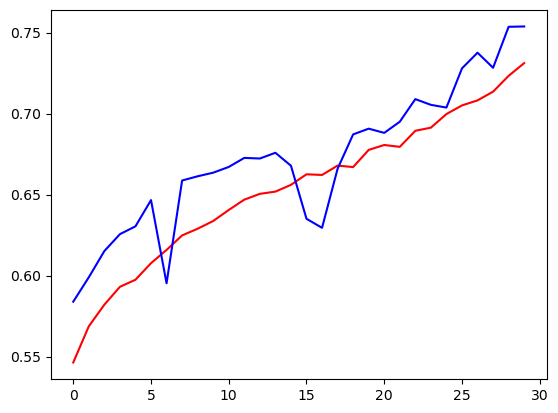

In [20]:
# plot binary_accury and val_binary_accuracy
plt.plot(history.epoch, history.history["binary_accuracy"], color="red")
plt.plot(history.epoch, history.history["val_binary_accuracy"], color="blue")

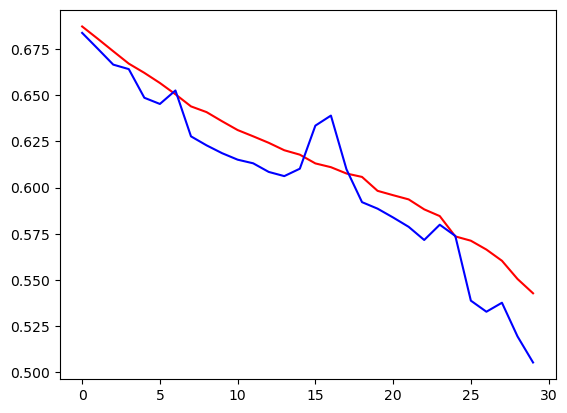

In [21]:
# plot loss and val_loss
plt.plot(history.epoch, history.history["loss"], color="red")
plt.plot(history.epoch, history.history["val_loss"], color="blue")

Note that we are using a dropout layer to improve generalization. This layer randomly shuts of connections during training. During testing, this layer is disabled and all connections are always enabled. This explains why the testing accuracy is often higher then the training accuracy, and the testing loss is often lower then the training loss.

<div class="alert alert-success">
<h3>Exercise</h3>

Many other optimizers exist besides the SGD optimizer that we used. For example, the Adam optimizer combines two extensions of SGD into one powerful optimizer. Try to use the Adam optimizer to fit the neural network. See how the training progresses - do you notice any difference compared to SGD?
    
<b>Note:</b> In order to retrain the classifier with another optimizer you have to reinstantiate the classifier.
</div>




In [22]:
with tf.device(device):
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    classifier.compile(optimizer=adam_optimizer, loss=bce_loss, metrics=[accuracy_metric])

In [23]:
with tf.device(device):
    history = classifier.fit(
        train_ds.batch(batch_size).repeat(), # on which data to we want to train
        epochs=epochs, # how many epochs do we want to run
        steps_per_epoch=steps_per_epoch, # how many steps are in one epoch
        validation_data=test_ds.batch(batch_size).repeat(), # what test data do we want to use
        validation_steps=test_steps # how many steps do we need to take when testing
    )

Epoch 1/30


2023-05-04 13:17:58.068610: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-04 13:17:58.121782: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-04 13:17:58.162545: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-04 13:17:58.206378: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Co

 8/86 [=>............................] - ETA: 0s - loss: 0.5576 - binary_accuracy: 0.7462 

2023-05-04 13:17:58.290700: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-04 13:17:58.332201: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.
2023-05-04 13:17:58.375133: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 11.1).  Compilation of XLA kernels below will likely fail.

You may not need to update CUDA; cherry-picking the ptxas binary is often sufficient.


86/86 [==============================] - 2s 18ms/step - loss: 0.5045 - binary_accuracy: 0.7585 - val_loss: 0.4890 - val_binary_accuracy: 0.7805
Epoch 2/30
86/86 [==============================] - 1s 17ms/step - loss: 0.4323 - binary_accuracy: 0.8045 - val_loss: 0.3928 - val_binary_accuracy: 0.8393
Epoch 3/30
86/86 [==============================] - 1s 17ms/step - loss: 0.3609 - binary_accuracy: 0.8536 - val_loss: 0.3192 - val_binary_accuracy: 0.8795
Epoch 4/30
86/86 [==============================] - 2s 18ms/step - loss: 0.3052 - binary_accuracy: 0.8854 - val_loss: 0.2954 - val_binary_accuracy: 0.8886
Epoch 5/30
86/86 [==============================] - 2s 19ms/step - loss: 0.2786 - binary_accuracy: 0.8990 - val_loss: 0.2850 - val_binary_accuracy: 0.8960
Epoch 6/30
86/86 [==============================] - 2s 18ms/step - loss: 0.2638 - binary_accuracy: 0.9067 - val_loss: 0.2692 - val_binary_accuracy: 0.9061
Epoch 7/30
86/86 [==============================] - 2s 19ms/step - loss: 0.2514 -

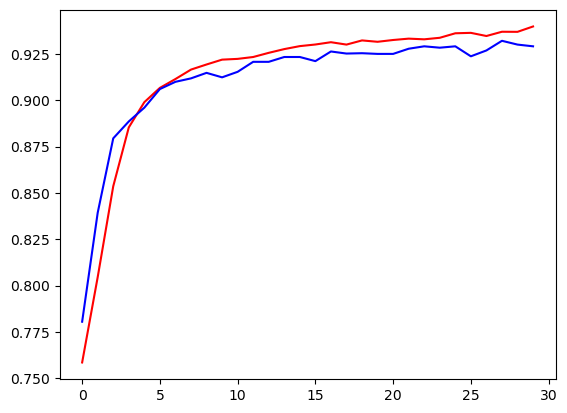

In [24]:
# plot binary_accury and val_binary_accuracy
plt.plot(history.epoch, history.history["binary_accuracy"], color="red")
plt.plot(history.epoch, history.history["val_binary_accuracy"], color="blue")

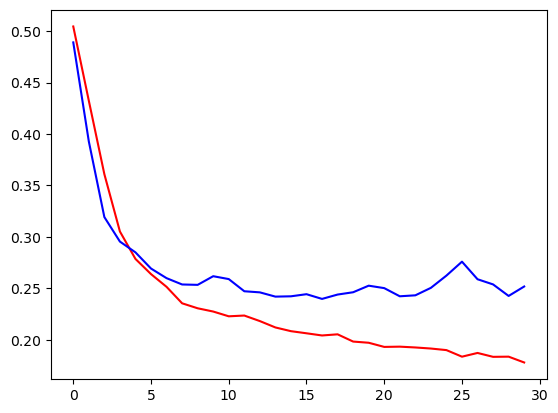

In [25]:
# plot loss and val_loss
plt.plot(history.epoch, history.history["loss"], color="red")
plt.plot(history.epoch, history.history["val_loss"], color="blue")

<div class="alert alert-success">
<h3>Exercise</h3>

Use the trained network to compute prediction scores for the test dataset. Use these scores to compute the confusion matrix and ROC AUC score.
    
</div>




In [26]:
from sklearn.metrics import confusion_matrix, roc_auc_score
true = [l.numpy() for i,l in test_ds.take(-1)]

In [27]:
scores = classifier.predict(test_ds.batch(batch_size)).ravel()

22/22 [==============================] - 0s 17ms/step


In [28]:
# compute confusion matrix
confusion_matrix(true, scores > 0.5)

array([[2488,  292],
       [ 104, 2628]])

In [29]:
# compute roc auc score
roc_auc_score(true, scores > 0.5)

0.9284483394250924

<h2 style="display: inline">Extra: A look at intermediate representations of the network</h2> <span style="float: right"><a href="#top">[back to top]</a></span> <a class="anchor" id="section_4"></a> 

As an image passes through our convolutional neural network, it is transformed by the operations defined in the layers. Each transformation extracts the most relevant information from the input it receives, and passes it on to the next layer. The output of each intermediate layer is called a feature map or *representation*.

By recording these intermediate representations for an image, we get an idea of what the network is focusing on to make its prediction. This way, we get some insight into the so-called *black-box model*.

In this last part we will look at some of the representations learned by the network we trained. Before running the code, think about what these representations might look like.

In [30]:
# extract some images to analyse
n_images = 10
it = iter(test_ds.batch(n_images))
images, labels = next(it)

# get the predictions
predictions = classifier.predict(images)

# record the intermediate representations
representations = []
record = [1, 2, 3]
x = images
for i, layer in enumerate(classifier.layers):
    x = layer(x)
    if i in record:
        representations.append(x)

1/1 [==============================] - 0s 75ms/step


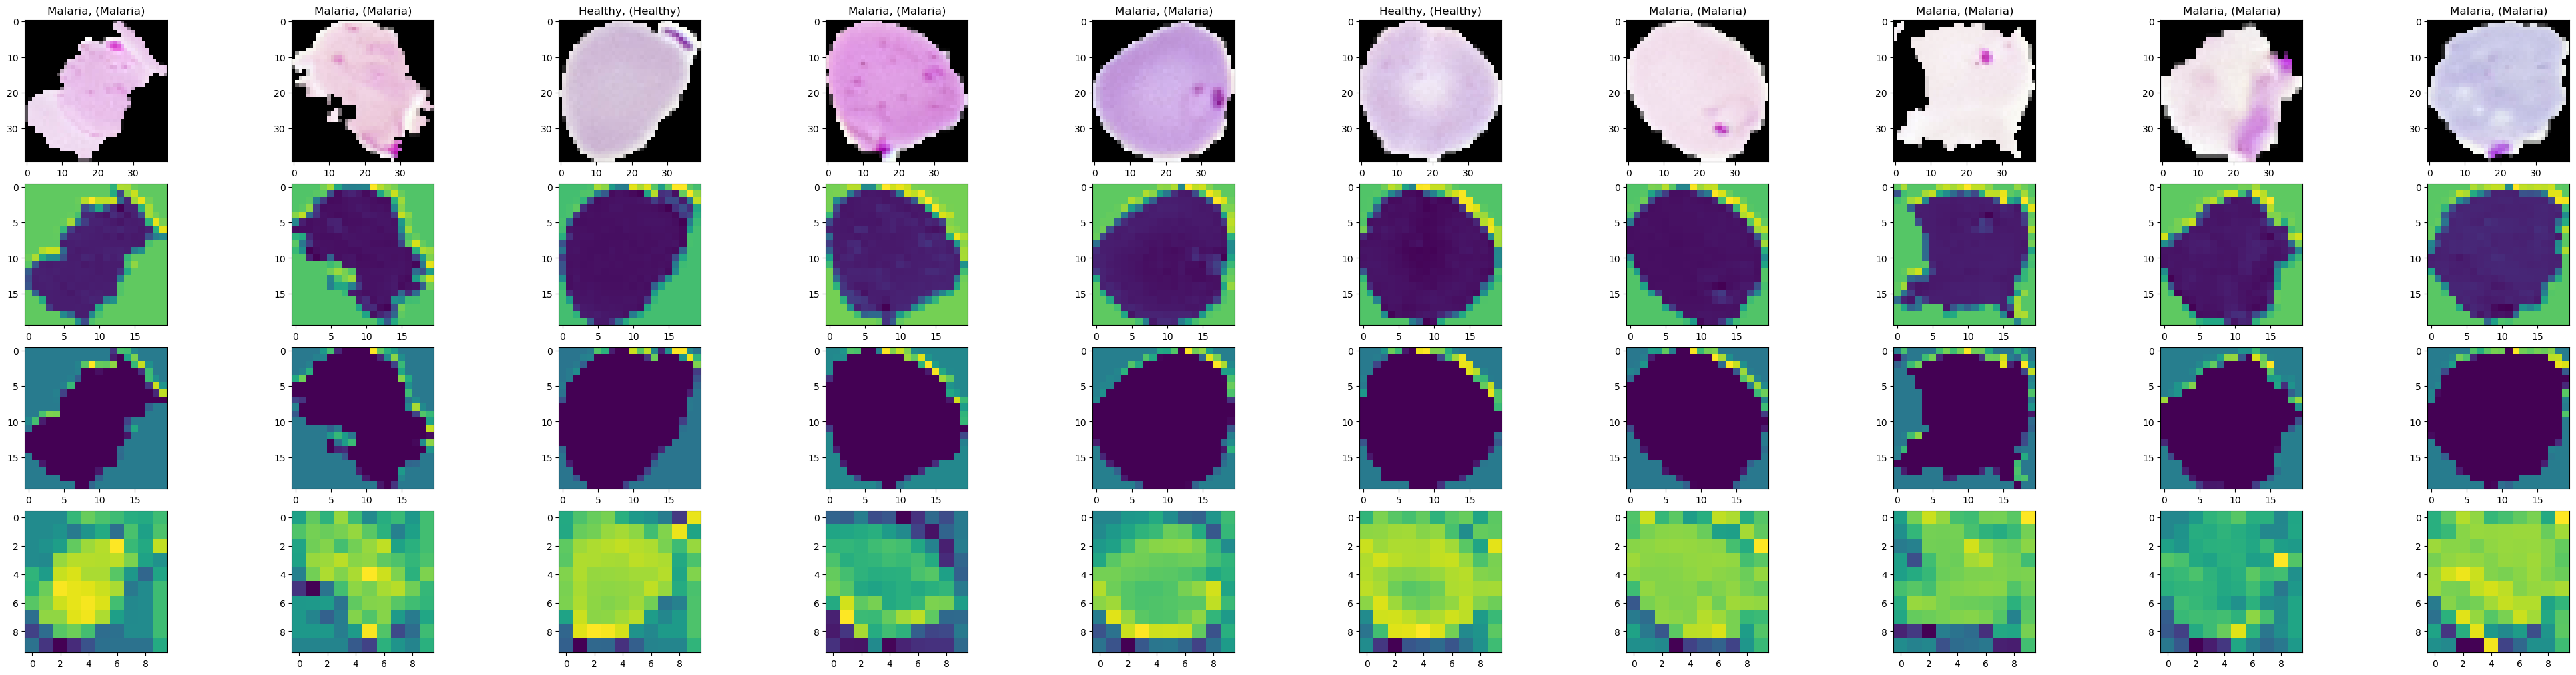

In [31]:
fig, axes = plt.subplots(1+len(representations), len(images), figsize=(40, 10), constrained_layout=True)
    
for ax,img,label,prediction in zip(axes[0, :], images, labels, predictions):
    ax.imshow(img)
    txt_label = "Healthy" if label.numpy() == 1 else "Malaria"
    txt_pred = "Healthy" if prediction > 0.5 else "Malaria"
    ax.set_title(f"{txt_label}, ({txt_pred})")
    
for reps, row in zip(representations, axes[1:, :]):
    for rep, ax in zip(reps, row):
        ax.imshow(rep[..., 0])